# 5 Train a classifier on the STL-10 dataset
In this notebook, we will again implement a classifier in Pytorch, with the difference that this time we will use a CNN instead of an MLP for classification. The dataset we will use is the STL-10 dataset. The STL-10 dataset contains images of airplanes, birds, cats, and more, each with a resolution of $96 \times 96$ pixels. We chose this dataset so that the training would run on lower performance computers, e.g. those without a graphics card.

However, classifiers do not work with the textual description of objects like "Airplane", "Bird", "Car" etc. instead each class is represented with a number. We define this representation first, as this will make things easier for us later. For this we choose the lexicographic sorting of the class names and index according to this order. We store the result in a dictionary (a list would also be sufficient).

## 1. Read the Data

In [2]:
import os
import numpy as np
import random
import glob
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset

from PIL import Image
import cv2

from tqdm import tqdm   # Progress-Bar

# Setze einen Seed für die Reproduzierbarkeit.
torch.manual_seed(1)

class_map_idx_to_str = {0: 'airplane',
                        1: 'bird', 
                        2: 'car', 
                        3: 'cat', 
                        4: 'deer', 
                        5: 'dog', 
                        6: 'horse', 
                        7: 'monkey', 
                        8: 'ship', 
                        9: 'truck'}


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False

seed_everything(1)

# Define the path to the folders train, val und test.
root_dir = "/kaggle/input/stl-10-dataset/STL-10_Dataset"

# Define a path to a folder containing trained weights.
checkpoint_path = "/kaggle/working/Checkpoint/last.pth.tar"

#If the checkpoints folder does not already exist create a new one
if not os.path.isdir(os.getcwd() + "/Checkpoint/"):
    os.makedirs(os.getcwd() + "/Checkpoint/")

# Load the current checkpoint (if existinoiutg), otherwise create a new one.
def create_or_load_checkpoint(model, epoch=-1, optimizer=None, last_loss=10**20):
    
    if os.path.isfile(checkpoint_path):
        print("=> Looking for checkpoint")
        try:
            checkpoint = torch.load(checkpoint_path)
            
            epoch = checkpoint['epoch']
            print("Loaded epoch number is", epoch)            
            last_loss = checkpoint['best_loss']
            print("Loaded best loss is", last_loss)
            model.load_state_dict(checkpoint['state_dict'], strict=False)
            # model.conv1.load_state_dict(checkpoint['state_dict']['conv1.weight'])
            print("Best Model Weights loaded")
            if not optimizer is None:
                optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> Found and loaded checkpoint")
        except:
            print("Your checkpoint does not contain trained weights. Your old weights will be overwritten.")
            torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_loss': last_loss, 'optimizer': optimizer.state_dict()}, checkpoint_path)
    else:
        torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_loss': last_loss, 'optimizer': optimizer.state_dict()}, checkpoint_path)
        print("=> No checkpoint found. You have to train first.")
    return epoch, last_loss

## 2. Image loading and augmentation


In [3]:
class Simple_Dataloader(Dataset):
    def __init__(self, root_dir, loader_mode):
        self.root_dir = root_dir
        self.loader_mode = loader_mode
        self.imgs = []
        for i in range(10):
            self.imgs += glob.glob(root_dir + os.sep + loader_mode + os.sep + class_map_idx_to_str.get(i) + '/*.png')

        self.transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.RandomRotation(15),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ColorJitter(brightness=0.5, saturation=0.3, hue=0.3),
            v2.RandomAffine(degrees=0, translate=(0.12, 0.12), shear=15),
            v2.RandomResizedCrop(size=(96,96), scale=(0.7, 1.2),antialias=True),
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx] # get the path of the image
        img = Image.open(img_path)  # open the Image/
        
        #Transform our PIL image to a tensor and apply augmentations
        img_torch = self.transform(img)

        label = os.path.basename(os.path.dirname(self.imgs[idx])) # get the lbl e.g('airplane')
        label_num = next(key for key, value in class_map_idx_to_str.items() if value == label) # get the numerical label

        return img_torch, torch.tensor(int(label_num))


## 2. Dataset to Dataloader 


In [4]:
batch_size_train = 32# 88
batch_size_val = 1

print("Cache Data:")

train_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="train")
val_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="val")
test_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="test")


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, pin_memory=True,
                                               shuffle=True, drop_last=False)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_val, pin_memory=True,
                                             shuffle=False, drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, pin_memory=True,
                                              shuffle=False, drop_last=False)

dataset_sizes = dict()
dataset_sizes["train"] = len(train_dataset.imgs)
dataset_sizes["val"] = len(val_dataset.imgs)
dataset_sizes["test"] = len(test_dataset.imgs)
dataset_sizes

Cache Data:


{'train': 4250, 'val': 250, 'test': 500}

In [4]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    print(img.shape)
    npimg= img.squeeze(0).numpy()
    print(npimg.shape)
    t_imag= np.transpose(npimg, (1, 2, 0))
    print(t_imag.shape)
    plt.figure(figsize =(5,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    plt.show()

#dataiter = iter(test_dataloader)
#images, labels = next(dataiter)
#number = labels.item()
#imshow(torchvision.utils.make_grid(images))
#labels = [class_map_idx_to_str[number.item()] for number in labels]

# Print the labels
#print("Labels:", labels)

## 3. Defining the Convolutional Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

which_model = 0

    
class Our_First_CNN_VGG(nn.Module):
    def __init__(self):
        super().__init__()
        #96 x 96 x 3
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride= 1, padding=(1, 1), bias=False) # 96 x 96 x 64
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride= 1, padding=(1, 1), bias=False) # 96 x 96 x 64
        self.bn1_2 = nn.BatchNorm2d(64)
        
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv2_1= nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride= 2, padding=(1, 1), bias=False) # 48 x 48 x 128
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2= nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride= 1, padding=(1, 1), bias=False) # 48 x 48 x 128
        self.bn2_2 = nn.BatchNorm2d(128)
        self.downsample2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(128),
        )
        
        self.dropout2 = nn.Dropout(0.25)
       
        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride= 2, padding=(1, 1), bias=False) # 24 x 24 x 256
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride= 1, padding=(1, 1), bias=False)# 24 x 24 x 256
        self.bn3_2 = nn.BatchNorm2d(256)
        
        self.downsample3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(256),
        )
        
        self.dropout3 = nn.Dropout(0.3)
        
        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride= 2, padding=(1, 1), bias=False)# 12 x 12 x 512
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride= 1, padding=(1, 1), bias=False)# 12 x 12 x 512
        self.bn4_2 = nn.BatchNorm2d(512)
        self.downsample4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(512),
        )
        self.dropout4 = nn.Dropout(0.4)
        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride= 1, padding=(1, 1), bias=False) # 12 x 12 x 512
        self.bn5_1 = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride= 1, padding=(1, 1), bias=False) # 12 x 12 x 512
        self.bn5_2 = nn.BatchNorm2d(512)
    
        self.pool = nn.MaxPool2d(2, 2) # 48 x 48 x 64# 6 x 6 x 512
        self.dropout5 = nn.Dropout(0.5)
    
        
        self.dropout6 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512 * 6 * 6, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)
        
        

    def forward(self, x):
        x = torch.relu(self.bn1_1(self.conv1_1(x)))
        x = torch.relu(self.bn1_2(self.conv1_2(x)))
        
        x = self.dropout1(x)
        
        identity2 = self.downsample2(x)
        x = torch.relu(self.bn2_1(self.conv2_1(x)))
        x = self.bn2_2(self.conv2_2(x))
        x += identity2
        x = torch.relu(x)
        
        x = self.dropout2(x)
        
        identity3 = self.downsample3(x)
        x = torch.relu(self.bn3_1(self.conv3_1(x))) 
        x = self.bn3_2(self.conv3_2(x))
       
        x += identity3
        x = torch.relu(x)
        
        x = self.dropout3(x)

        identity4 = self.downsample4(x)
        x = torch.relu(self.bn4_1(self.conv4_1(x)))
        x = self.bn4_2(self.conv4_2(x))
    
        x += identity4
        x = torch.relu(x)
        
        x = self.dropout4(x)
        
        identity5 = x
        x = torch.relu(self.bn5_1(self.conv5_1(x)))
        x = self.bn5_2(self.conv5_2(x))
        x += identity5
        x = torch.relu(x)
        
        x = self.pool(x)# 6 x 6 x 512
        x = self.dropout5(x)

        x = torch.flatten(x, 1) 
        x = torch.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout6(x)
        x = self.fc2(x)
        return x

    
def resnet34(num_classes=10):
    # Lade das ResNet34
    model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
    
    # Die Anzahl der eingehenden Neuronen in den letzten Layer des ResNet34 werden in der Variable num_features gespeichert.
    num_features = model.fc.in_features
    
    # Ändere die Anzahl ausgehender Neuronen im letzten Layer des ResNet34, indem ein neuer Fully-Connected Layer 
    # zugewiesen wird.
    model.fc = torch.nn.Linear(num_features, num_classes)  # First fully connected layer with 100 output unit
    
    return model



In [6]:
model = None

if which_model == 0:
    model = Our_First_CNN_VGG()
else:
    model = resnet34(num_classes=len(class_map_idx_to_str))
    

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
count_parameters(model)

19025610

## 4. Implementation of the Training 

In [9]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print, best_score=None):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = best_score
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, epoch,val_loss, optimizer, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch,val_loss, optimizer, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch,val_loss, optimizer, model)
            self.counter = 0

    def save_checkpoint(self, epoch,val_loss, optimizer, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func('')
            self.trace_func('---------********************************----------')
            self.trace_func('----------New best model found and saved.----------')
            self.trace_func('---------********************************----------')
            self.trace_func('')
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        #torch.save({'epoch': epoch, 'state_dict': model.state_dict(),'best_loss': val_loss, 'optimizer': optimizer.state_dict()},self.path)
        self.val_loss_min = val_loss

In [10]:
import torch.optim as optim
from torch.optim import lr_scheduler
import sys
import copy
import multiprocessing


num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores available: {num_cores}")


# Wenn Sie eine NVIDIA Grafikkarte besitzen und CUDA installiert ist, können Sie diesen Wert zu "cuda" ändern.
#device = "cpu"
device = "cuda"


def train_model(model, num_epochs=100):
    best_eval_loss =  sys.float_info.max
    dataloader = {'train': train_dataloader,'eval':val_dataloader}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer= optim.AdamW(model.parameters(), lr=0.001,weight_decay=0.3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=8, factor=0.1, min_lr=0.00001)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.01)
    
    #load resnet best weights (model, epoch=-1, optimizer=None, last_loss=10**20):
    epoch, last_loss = create_or_load_checkpoint(model,-1,optimizer)
    #set the best eval loss
    best_eval_loss = last_loss
    
    #path to current model
    early_stopping = EarlyStopping(30,verbose=True, path='/kaggle/working/Checkpoint/new.pth.tar',best_score=-best_eval_loss)

    for epoch in range(num_epochs):        
        if early_stopping.early_stop:
            print("Early stopping")
            break

        for phase in ['train','eval']:
            if phase == 'train':
                 model.train()    
            else:
                model.eval() 
                
            running_loss = 0
            
            for inputs, labels in tqdm(dataloader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # zero the parameter gradients
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) #forward propagation

                    loss = criterion(outputs, labels) #calculate the loss

                    if phase == 'train': 
                        loss.backward()   # backpropagation
                        optimizer.step() #update the weights
                running_loss += loss.item() # update the running_loss
            
            loss = running_loss/ len(dataloader[phase])
            print(f'Epoch {epoch + 1} {phase} loss: {loss:.4f}')
            if phase == 'eval':
                scheduler.step(loss)
                print('')
                print(f"Learning rate {optimizer.param_groups[0]['lr']}")
                early_stopping(epoch,loss,optimizer,model) # early stopping using eval loss
                
           
        

Number of CPU cores available: 4


## 5. Training und Validation


In [11]:
train_model(model,10)

=> Looking for checkpoint
Loaded epoch number is 14
Loaded best loss is 0.5946564374397713
Best Model Weights loaded
=> Found and loaded checkpoint


100%|██████████| 133/133 [00:41<00:00,  3.18it/s]


Epoch 1 train loss: 0.3575


100%|██████████| 250/250 [00:02<00:00, 98.03it/s] 


Epoch 1 eval loss: 0.7064

Learning rate 0.0001
EarlyStopping counter: 1 out of 30


100%|██████████| 133/133 [00:31<00:00,  4.16it/s]


Epoch 2 train loss: 0.3726


100%|██████████| 250/250 [00:02<00:00, 119.65it/s]


Epoch 2 eval loss: 0.7004

Learning rate 0.0001
EarlyStopping counter: 2 out of 30


100%|██████████| 133/133 [00:31<00:00,  4.27it/s]


Epoch 3 train loss: 0.3857


100%|██████████| 250/250 [00:02<00:00, 122.19it/s]


Epoch 3 eval loss: 0.7211

Learning rate 0.0001
EarlyStopping counter: 3 out of 30


100%|██████████| 133/133 [00:31<00:00,  4.22it/s]


Epoch 4 train loss: 0.4126


100%|██████████| 250/250 [00:01<00:00, 125.51it/s]


Epoch 4 eval loss: 0.6832

Learning rate 0.0001
EarlyStopping counter: 4 out of 30


100%|██████████| 133/133 [00:31<00:00,  4.24it/s]


Epoch 5 train loss: 0.4120


100%|██████████| 250/250 [00:01<00:00, 126.79it/s]


Epoch 5 eval loss: 0.7048

Learning rate 0.0001
EarlyStopping counter: 5 out of 30


100%|██████████| 133/133 [00:31<00:00,  4.26it/s]


Epoch 6 train loss: 0.4414


100%|██████████| 250/250 [00:01<00:00, 128.01it/s]


Epoch 6 eval loss: 0.7277

Learning rate 0.0001
EarlyStopping counter: 6 out of 30


100%|██████████| 133/133 [00:30<00:00,  4.38it/s]


Epoch 7 train loss: 0.4626


100%|██████████| 250/250 [00:02<00:00, 121.25it/s]


Epoch 7 eval loss: 0.7113

Learning rate 0.0001
EarlyStopping counter: 7 out of 30


100%|██████████| 133/133 [00:30<00:00,  4.37it/s]


Epoch 8 train loss: 0.4888


100%|██████████| 250/250 [00:01<00:00, 125.92it/s]


Epoch 8 eval loss: 0.7454

Learning rate 0.0001
EarlyStopping counter: 8 out of 30


100%|██████████| 133/133 [00:30<00:00,  4.38it/s]


Epoch 9 train loss: 0.5274


100%|██████████| 250/250 [00:01<00:00, 127.43it/s]


Epoch 9 eval loss: 0.7773

Learning rate 0.0001
EarlyStopping counter: 9 out of 30


100%|██████████| 133/133 [00:30<00:00,  4.39it/s]


Epoch 10 train loss: 0.5628


100%|██████████| 250/250 [00:01<00:00, 130.65it/s]

Epoch 10 eval loss: 0.8400

Learning rate 0.0001
EarlyStopping counter: 10 out of 30


## 6. Evaluation of the Model 
Show the accuracy of the model and create a confusion matrix.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


def test_model(model, test_dataset):
    # Set model to evaluation mode
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Initialize lists to store the true labels and predictions
    true_labels = []
    pred_labels = []
    # Iterate over the data
    for inputs, labels in tqdm(test_dataset):
        # Move data to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            # Get model predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # Append true labels and predictions to the lists
            true_labels.append(labels.item())
            pred_labels.append(preds.item())
    # Convert the lists to numpy arrays
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    # Compute the confusion matrix
    accuracy = (true_labels == pred_labels).mean()
    print(f'the accuracy is {accuracy *100}')
    cm = confusion_matrix(true_labels, pred_labels)
    return cm

In [17]:
res = torch.load("/kaggle/working/Checkpoint/last.pth.tar") #loading different models
print(res['best_loss']) 
#model.load_state_dict(res['state_dict']) # load best model weights

cm = test_model(model, test_dataloader) #build confusion matrix and show accuracy

0.5946564374397713


100%|██████████| 500/500 [00:03<00:00, 128.33it/s]

the accuracy is 76.4


## 7. Confusion Matrix Visualization


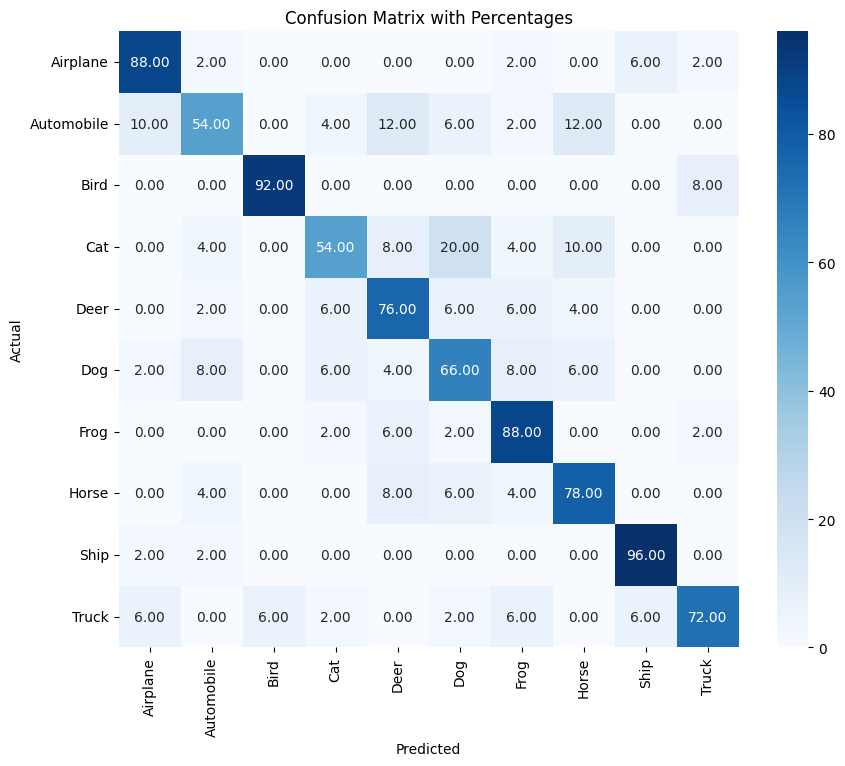

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Calculate the percentages
confusion_matrix_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_percent, annot=True, fmt=".2f", cmap="Blues", cbar=True, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix with Percentages')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## 8. Compare against finetuned ResNet-34

In [10]:
model = resnet34(num_classes=len(class_map_idx_to_str)) # load the resnet-34

res = torch.load("/kaggle/working/Checkpoint/res.pth.tar") #load resnet-34 best weight
print(res['best_loss']) 

model.load_state_dict(res['state_dict']) # load best model weights

cm = test_model(model, test_dataloader) #build confusion matrix and show accuracy

0.41644790520239555


100%|██████████| 500/500 [00:08<00:00, 61.58it/s]

the accuracy is 85.39999999999999


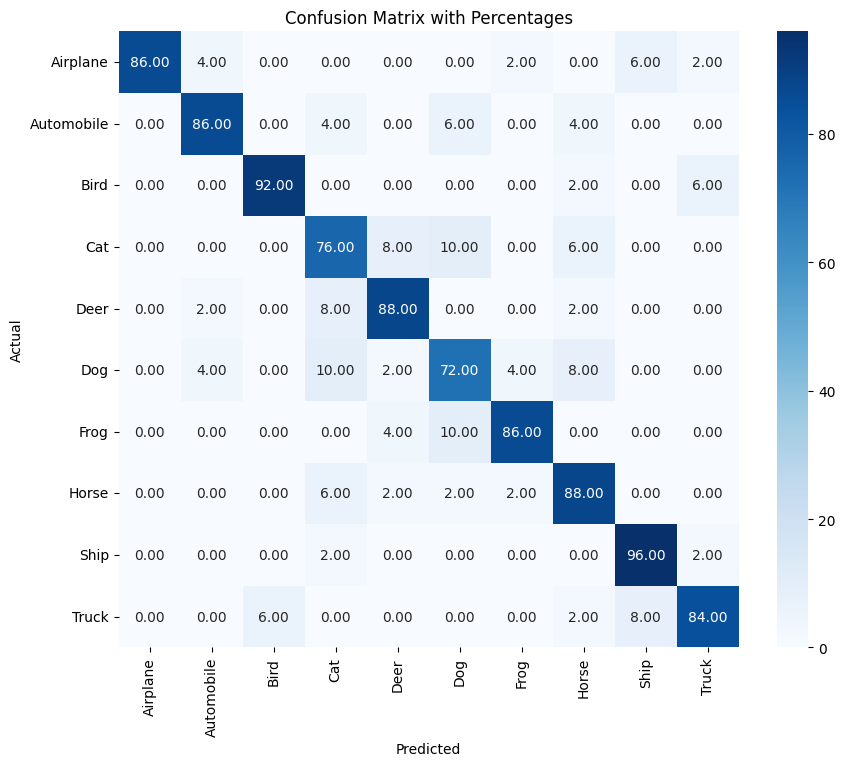

In [13]:
class_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Calculate the percentages
confusion_matrix_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_percent, annot=True, fmt=".2f", cmap="Blues", cbar=True, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix with Percentages')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
